In [160]:
import os
import zipfile
import pandas as pd

# Module constants
DATASET_DIR = os.path.join(os.getcwd(), 'datasets')
TRAINING_CSV =  os.path.join(DATASET_DIR, 'train.csv')
TEST_CSV = os.path.join(DATASET_DIR, 'test.csv')
DATA_ZIP = os.path.join(DATASET_DIR, 'all.zip')

# get dataset if flat file not readily available
def get_csv_from_zip(train_set=True):
    csv = TRAINING_CSV if train_set else TEST_CSV

    with zipfile.ZipFile(DATA_ZIP) as data_zip:
        member = 'train.csv' if train_set else 'test.csv'
        data_zip.extract(member, path=DATASET_DIR)

# load data via pandas
def load_dataset(csv=TRAINING_CSV):
    if not os.path.isfile(csv):
        get_csv_from_zip()

    return pd.read_csv(csv)

# Get dataset info
x_train = load_dataset()
x_train.info()

# Info summary
"""
- 891 total entries
- Missing data for Age: 714, Cabin: 204, and Embarked: 889
- Name, Sex, Ticket, Cabin, and Embarked are non-numerical data
"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


'\n- 891 total entries\n- Missing data for Age: 714, Cabin: 204, and Embarked: 889\n- Name, Sex, Ticket, Cabin, and Embarked are non-numerical data\n'

In [161]:
# Get overview of dataframe
x_train.head()

# Summary
"""
- drop PassengerId since unique to each row and doesn't provide any useable info
- drop Name, Ticket, and Cabin since can't convert into useful label encoding
- change Sex and Embarked into categorical datatype in dataframe
- update Sex with its category codes instead of text labels
- one-hot encode Embarked since its categorical but want to consume as binary and then drop from df
"""

"\n- drop PassengerId since unique to each row and doesn't provide any useable info\n- drop Name, Ticket, and Cabin since can't convert into useful label encoding\n- change Sex and Embarked into categorical datatype in dataframe\n- update Sex with its category codes instead of text labels\n- one-hot encode Embarked since its categorical but want to consume as binary and then drop from df\n"

In [314]:
"""
Classes to be used in sklean pipeline as data transformers
"""
from sklearn.base import BaseEstimator, TransformerMixin

# Feature drop transformer class
class DropFeatureTransformer(BaseEstimator, TransformerMixin):
    """Pipeline transformer for dropping specific features."""
    def __init__(self, drop_list='Survived'):
        """Drop Survived feature by default."""
        self.drop_list = drop_list
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(self.drop_list, axis=1)

# DataSet transformer class
class TitanicDataTransformer(BaseEstimator, TransformerMixin):
    """Pipeline transformer for feature engineering."""
    def __init__(self, drop_defaults=True):
        """Drop unwanted features by default."""
        self.drop_defaults = drop_defaults
        
        # list of features to exclude for modeling
        self.unwanted_features = [
            'PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked'
        ]
        
    def _get_fare_pp(self, df):
        """Calculate fare per passenger based on fare for each ticket."""
        tix_counts = df['Ticket'].value_counts()
        n_row = len(x_train)
        fare_pp = []

        for idx in range(n_row):
            row = df.iloc[idx]
            fpp = row.Fare / tix_counts.at[row.Ticket]
            fare_pp.append(fpp)
        df['Fare_PP'] = fare_pp
        
        return df
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):        
        # change Sex and Embarked into categorical datatype
        df_tr = X.astype({'Sex': 'category', 'Embarked': 'category'})
        
        # recode Sex using category codes
        df_tr['Sex'] =  df_tr['Sex'].cat.codes
        
        # one-hot-encode Embarked
        one_hot_encode = pd.get_dummies(df_tr['Embarked'], prefix='Embarked', dtype=int)
        df_tr = df_tr.join(other=one_hot_encode)
        
        # Engineer Fare_Expensive feature to categorize passengers with Fares > 31
        df_tr['Fare_Expensive'] = [2 if f > 31 else 0 if f < 7 else 1 for f in df_tr.Fare]
        
        # Enginer Adult feature to categorize passengers with Age >= 18
        df_tr['Adult'] = [1 if age >= 18 else 0 for age in df_tr.Age]
        
        # Enginer Age feature to categorize passengers into 0-15, 16-64, 65+
        df_tr['Age_3Cat'] = [2 if age >= 65 else 0 if age < 16 else 1 for age in df_tr.Age]
        
        # Enginer Adult feature to categorize passengers into 0-14, 15-24, 25-54, 55-64, 65+
        df_tr['Age_5Cat'] = [0 if age < 15 else 1 if age < 25 else 2 if age < 55
                             else 3 if age < 65 else 4 for age in df_tr.Age]
        
        # Fill-nas for Age using median
        df_tr['Age_Median'] = df_tr['Age'].fillna(df_tr['Age'].median())
        # Enginer Adult feature to categorize passengers with Age >= 18
        df_tr['Adult_Median'] = [1 if age >= 18 else 0 for age in df_tr.Age_Median]
        
        # Enginer Age feature to categorize passengers into 0-15, 16-64, 65+
        df_tr['Age_Median_3Cat'] = [2 if age >= 65 else 0 if age < 16 else 1 for age in df_tr.Age_Median]
        
        # Enginer Adult feature to categorize passengers into 0-14, 15-24, 25-54, 55-64, 65+
        df_tr['Age_Median_5Cat'] = [0 if age < 15 else 1 if age < 25 else 2 if age < 55
                             else 3 if age < 65 else 4 for age in df_tr.Age_Median]
        
        # Engineer Fare Per Passenger (Fare_PP) feature since current fare is per ticket not by passenger
        df_tr = self._get_fare_pp(df_tr)
        
        # Engineer Fare_PP_Expensive feature to categorize passengers with Fares > 24
        df_tr['Fare_PP_Expensive'] = [2 if f > 24 else 0 if f < 7 else 1 for f in df_tr.Fare_PP]
        
        # drop default unwanted features if requested
        if self.drop_defaults:
            # drop defaults
            df_tr = df_tr.drop(self.unwanted_features, axis=1)
        
        return df_tr

tr_ = TitanicDataTransformer()
x_train_tr = tr_.transform(x_train)
x_train_tr.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Fare_PP,Embarked_C,Embarked_Q,Embarked_S,Fare_Expensive,Adult,Age_3Cat,Age_5Cat,Age_Median,Adult_Median,Age_Median_3Cat,Age_Median_5Cat,Fare_PP_Expensive
0,0,3,1,22.0,1,0,7.2500,7.2500,0,0,1,1,1,1,1,22.0,1,1,1,1
1,1,1,0,38.0,1,0,71.2833,71.2833,1,0,0,2,1,1,2,38.0,1,1,2,2
2,1,3,0,26.0,0,0,7.9250,7.9250,0,0,1,1,1,1,2,26.0,1,1,2,1
3,1,1,0,35.0,1,0,53.1000,26.5500,0,0,1,2,1,1,2,35.0,1,1,2,2
4,0,3,1,35.0,0,0,8.0500,8.0500,0,0,1,1,1,1,2,35.0,1,1,2,1


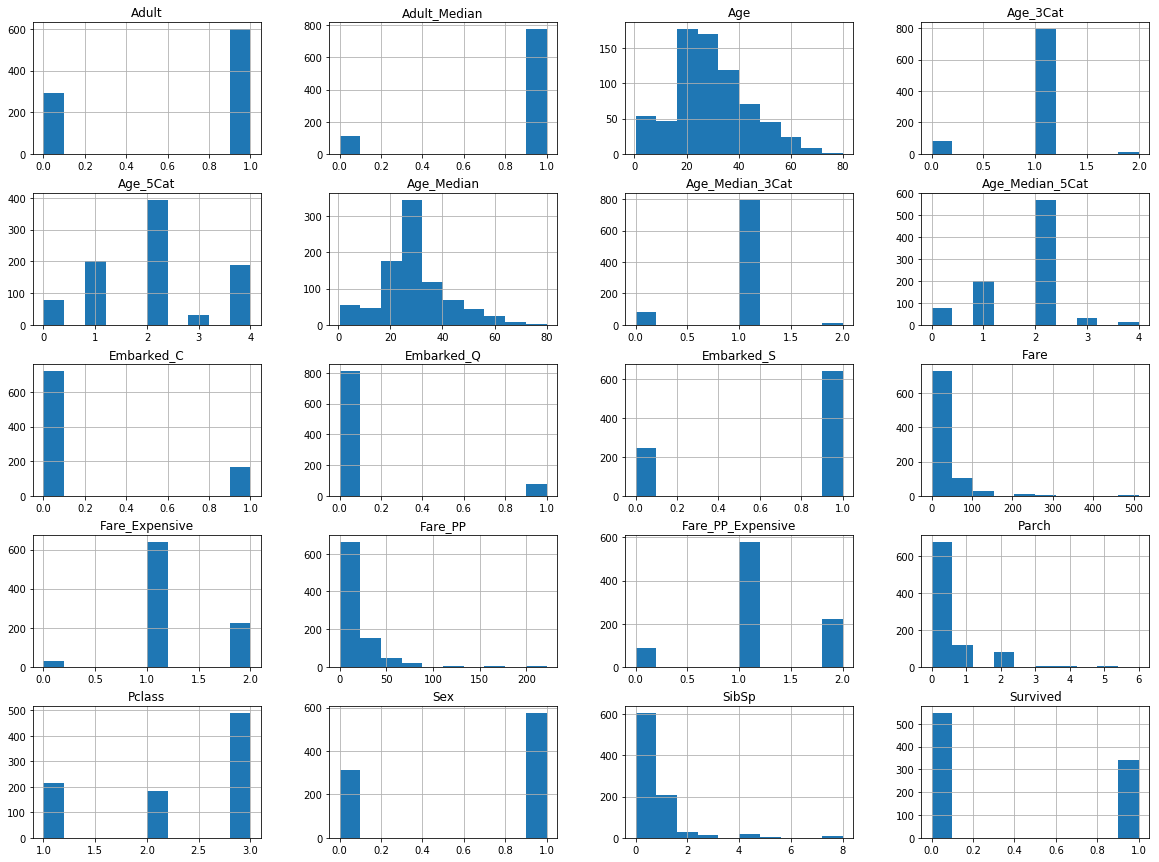

"\n- Age is nearly normal with slight right skew. Not many children onboard the titanic.\n    ** Consider engineering feature for 'Minor': age < 18?\n        - doesn't seem to be much of a differentiator\n    ** Considering engineering feature by age categories using Age structure from UK Demography wiki\n        (https://en.wikipedia.org/wiki/Demography_of_the_United_Kingdom)\n        - Age_5Cat 0-14, 15-24, 25-54, 55-64, 65+\n        - alternatively, Age_3Cat: 0-15, 16-64, 65+ (https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/articles/overviewoftheukpopulation/february2016)\n        * seing better differentiation between minors than groups with respect to survivorship that might be\n            useful. Note - concern missing values for some passengers: will fill with median values to see effect\n            - worked actually pretty well, removed the NAs out of the 65+ category and had minimial impact\n                on median category di

In [315]:
# Intial data visualization
%matplotlib inline
import matplotlib.pyplot as plt

x_train_tr.hist(bins=10, figsize=(20, 15))
plt.show()

"""
- Age is nearly normal with slight right skew. Not many children onboard the titanic.
    ** Consider engineering feature for 'Minor': age < 18?
        - doesn't seem to be much of a differentiator
    ** Considering engineering feature by age categories using Age structure from UK Demography wiki
        (https://en.wikipedia.org/wiki/Demography_of_the_United_Kingdom)
        - Age_5Cat 0-14, 15-24, 25-54, 55-64, 65+
        - alternatively, Age_3Cat: 0-15, 16-64, 65+ (https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/articles/overviewoftheukpopulation/february2016)
        * seing better differentiation between minors than groups with respect to survivorship that might be
            useful. Note - concern missing values for some passengers: will fill with median values to see effect
            - worked actually pretty well, removed the NAs out of the 65+ category and had minimial impact
                on median category distributions vs survivorship
- Very few passengers embarked from Queenstown (Cobh), Ireland; less than 200 embarked from
    Cherbourg, France; > 600 embarked from Southampton, England
- Fare is skewed right, with > 700 passengers paying less thatn 50 pounds
    ** Consider engineering feature for 'VIP': fare > 50; or rather fare > 31
        - did not get that much better improvement from this; most likely due to next comment
    ** Fare seems like an agregate by ticket, not per person
        - maybe what is really needed is price per ticket -> Fare_PP
        - additionally Fare_PP_Expensive with Fare_PP > 24 (75th-percentile = 24.288)
    ** Fare_Expensive & Fare_PP are very similarly distributed if not the same, so let's consider
        adding 3 tiers -> low, mod, high: 0, 1, 2
        - using distribution, thinking: Fare_Expensive: < 7, < 31, > 31; respective
        - similarly, thinking: Fare_PP_Expensive: < 7, < 24, > 24; respectively
        - a little bit of differentiation between the two now, primarily in 0 vs 1 category
- Parch skewed right with > 600 with 0, which is expected since not many children onboard
- Pclass: majority in 3rd (lower) class, 1st and 2nd class ~ 200 passengers each; about 500 passengers in 3rd class
- Sex: twice as many men than women passages - ~300 women to ~ 600 men
- SibSp skewed right with > 600 with 0
- Survived, as we know most passengers did not: ~550 died and ~350 survived
"""

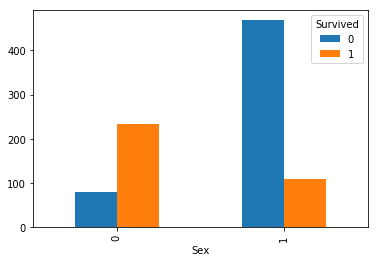

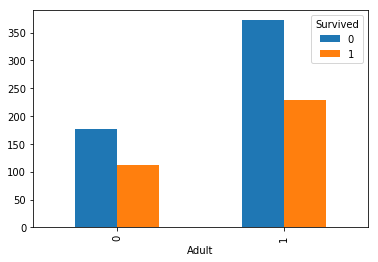

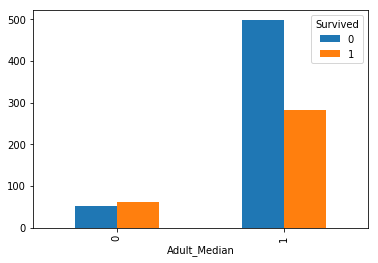

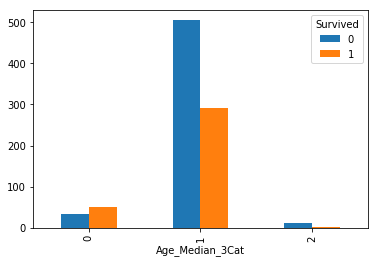

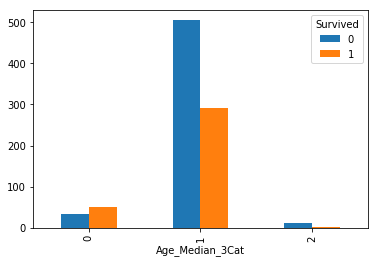

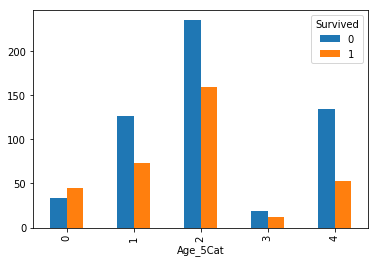

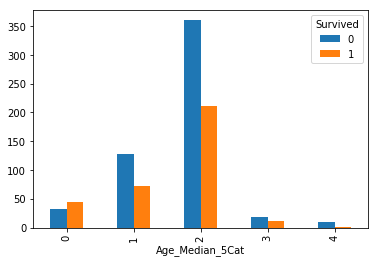

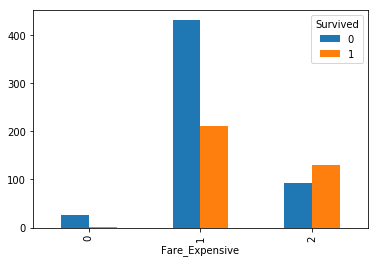

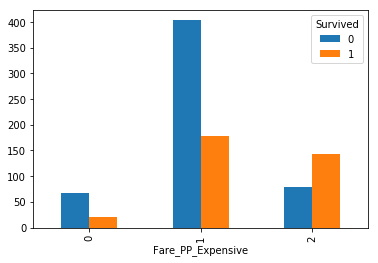

In [296]:
# Visual Sex, Fare_Expensive, and Adult features by survivorship

s = x_train_tr.groupby(['Sex', 'Survived'])['Survived'].count().unstack()
s.plot.bar()

a = x_train_tr.groupby(['Adult', 'Survived'])['Survived'].count().unstack()
a.plot.bar()

a_med = x_train_tr.groupby(['Adult_Median', 'Survived'])['Survived'].count().unstack()
a_med.plot.bar()

a_3Cat = x_train_tr.groupby(['Age_Median_3Cat', 'Survived'])['Survived'].count().unstack()
a_3Cat.plot.bar()

a_med_3Cat = x_train_tr.groupby(['Age_Median_3Cat', 'Survived'])['Survived'].count().unstack()
a_med_3Cat.plot.bar()

a_5Cat = x_train_tr.groupby(['Age_5Cat', 'Survived'])['Survived'].count().unstack()
a_5Cat.plot.bar()

a_med_5Cat = x_train_tr.groupby(['Age_Median_5Cat', 'Survived'])['Survived'].count().unstack()
a_med_5Cat.plot.bar()

f = x_train_tr.groupby(['Fare_Expensive', 'Survived'])['Survived'].count().unstack()
f.plot.bar()

f_pp = x_train_tr.groupby(['Fare_PP_Expensive', 'Survived'])['Survived'].count().unstack()
f_pp.plot.bar()

In [300]:
corr_matrix = x_train_tr.corr()
print(corr_matrix['Survived'].sort_values(ascending=False))

# Notes
"""
- Filling in missing age for passengers with median didn't seem to affect relationship to survivorship.
    * there some slight negative correlation between age and survivorship, Age_Median_3Cat seems to
        the better of the related features
- should take a closer look at the relationship betweent he following:
    Survived, Fare_PP_Expensive, Embarked_C, Age_Median_3Cat, Embarked_S, Pclass, and Sex
"""

Survived             1.000000
Fare_PP_Expensive    0.290818
Fare                 0.257307
Fare_PP              0.254824
Fare_Expensive       0.251079
Embarked_C           0.168240
Parch                0.081629
Embarked_Q           0.003650
Adult               -0.008309
SibSp               -0.035322
Age_Median          -0.064910
Age                 -0.077221
Age_Median_5Cat     -0.102386
Adult_Median        -0.122239
Age_5Cat            -0.123755
Age_3Cat            -0.149384
Age_Median_3Cat     -0.149384
Embarked_S          -0.155660
Pclass              -0.338481
Sex                 -0.543351
Name: Survived, dtype: float64


"\n- Fill missing age for passengers with median didn't seem to affect relationship to survivorship.\n    * there some slight negative correlation between age and survivorship, Age_Median_3Cat seems to\n        the better of the related features\n\n"

In [312]:
# Closer look at the features with ~ +- 0.15 correlation with survivorship and the relationship amongst themselves

x_train_f_chosen = x_train_tr[['Survived', 'Sex', 'Pclass', 'Fare_PP_Expensive', 'Embarked_C', 'Embarked_S', 'Age_Median_3Cat']]
x_train_f_chosen.corr()

# NOTES
# - Pclass and Fare_PP_Expensive seem to have a strong relationship so we can consider dropping Fare_PP_Expensive
# since Pclass has a stronger relationship to Survived 
# - Sex has weak relationship to over features, so keep. The strongest is with Age which is probably due to
# there being many more men on the Titanic than women and such would also constitude the older categories
# - Passengers who embarked from Cherbough have some relationship to expensive and 1st class, might consider dropping
# - Passengers who embarked from Southampton so might keep in place of dropping Embacked_C
# - Age some weak relationships to Sex, Pclass, and such Fare; most likely due skewnewss of Sex -> Male and
# Male -> Older

# Top 3 unique cat: Sex, Pclass, and Age_Median_3Cat
#  - Embarked and Fare tend to have weak/strong relationship to Pclass so probably good ideas to exclude
#  for comparison reaons

## Summary
# Train models with two selected features subsets:
# - train_base -> Sex, Pclass, Fare_PP_Expensive, Embarked_C, Embarked_S, and Age_Median_3Cat
# - train_top3 -> Sex, Pclass, and Age_Median_3Cat

,Survived,Sex,Pclass,Fare_PP_Expensive,Embarked_C,Embarked_S,Age_Median_3Cat
Survived,1.000000,-0.543351,-0.338481,0.290818,0.168240,-0.155660,-0.149384
Sex,-0.543351,1.000000,0.131900,-0.095134,-0.082853,0.125722,0.131631
Pclass,-0.338481,0.131900,1.000000,-0.735448,-0.243292,0.081720,-0.139943
Fare_PP_Expensive,0.290818,-0.095134,-0.735448,1.000000,0.258633,-0.150936,0.275444
Embarked_C,0.168240,-0.082853,-0.243292,0.258633,1.000000,-0.778359,-0.012990
Embarked_S,-0.155660,0.125722,0.081720,-0.150936,-0.778359,1.000000,-0.015618
Age_Median_3Cat,-0.149384,0.131631,-0.139943,0.275444,-0.012990,-0.015618,1.000000


In [320]:
## Setup pipelines for train_base and train_top3
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion

# Constants needed for pipelines
TRAIN_TARGET = x_train['Survived']
BASE_FEAT_DROP_LIST = ['Survived', 'Fare', 'Fare_PP', 'Fare_Expensive', 'Parch', 'Embarked_Q',
                 'Adult', 'SibSp', 'Age_Median', 'Age', 'Age_Median_5Cat', 'Adult_Median',
                 'Age_5Cat', 'Age_3Cat']
TOP3_FEAT_DROP_LIST = ['Survived', 'Fare', 'Fare_PP', 'Fare_Expensive', 'Parch', 'Embarked_Q',
                 'Adult', 'SibSp', 'Age_Median', 'Age', 'Age_Median_5Cat', 'Adult_Median',
                 'Age_5Cat', 'Age_3Cat', 'Fare_PP_Expensive', 'Embarked_C', 'Embarked_S']
FEAT_BASE = ['Sex', 'Pclass', 'Fare_PP_Expensive', 'Embarked_C', 'Embarked_S', 'Age_Median_3Cat']
FEAT_TOP3= ['Sex', 'Pclass', 'Age_Median_3Cat']

# For QC purposes: Master set of features not to be used for modeling
# Survived             1.000000
# Fare                 0.257307
# Fare_PP              0.254824
# Fare_Expensive       0.251079
# Parch                0.081629
# Embarked_Q           0.003650
# Adult               -0.008309
# SibSp               -0.035322
# Age_Median          -0.064910
# Age                 -0.077221
# Age_Median_5Cat     -0.102386
# Adult_Median        -0.122239
# Age_5Cat            -0.123755
# Age_3Cat            -0.149384


base_pipeline = Pipeline([
    ('titanic_transform', TitanicDataTransformer()),
    ('drop_feat', DropFeatureTransformer(drop_list=BASE_FEAT_DROP_LIST)),
    ('std_scalar', StandardScaler())
])

top3_pipeline = Pipeline([
    ('titanic_transform', TitanicDataTransformer()),
    ('drop_feat', DropFeatureTransformer(drop_list=TOP3_FEAT_DROP_LIST)),
    ('std_scalar', StandardScaler())
])

# Get transformed training data sets
train_base = base_pipeline.fit_transform(x_train)
train_top3 = top3_pipeline.fit_transform(x_train)

In [360]:
## Setup pipelines for evaluating classification models
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score
from sklearn.linear_model import SGDClassifier, LogisticRegression

class EvaluateClassificationModel():
    def __init__(self, data_dict, target, random_state=42, cv=20):
        self.data_dict = data_dict
        self.target = target
        self.random_state = random_state
        self.cv = cv
    
    def _display_accuracy_scores(self, names, score_list):
        for idx in range(len(names)):
            scores = score_list[idx]
            print('\nDisplaying accuracy results for ', names[idx])
            print('\t\tScores:', scores)
            print('\t\tMean:', scores.mean())
            print('\t\tStandard deviation:', scores.std())
            print()
            
    def _display_prediction_metrics(self, names, preds_list):       
        for idx in range(len(names)):
            pred = preds_list[idx]
            print('\nDisplaying other scores for ', names[idx])
            print('\t\tConfusion Matrix:\n', confusion_matrix(self.target, pred))
            print('\t\tPrecision score:', precision_score(self.target, pred))
            print('\t\tRecall score:', recall_score(self.target, pred))
            print('\t\tF1 score:', f1_score(self.target, pred))
    
    def _graph_ROC_curve(self, names, probas_pred_list): 
        plt.figure(figsize=(20, 15))
        
        for idx in range(len(names)):
            name = names[idx]
            probas_pred = probas_pred_list[idx]
            precisions, recalls, thresholds = precision_recall_curve(self.target, probas_pred)
            fpr, tpr, roc_thresholds = roc_curve(self.target, probas_pred)
            average_precision = average_precision_score(self.target, probas_pred)
            auc = roc_auc_score(self.target, probas_pred)
            
            plt.subplot(2, 2, idx + 1)
            plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
            plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='b')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.ylim([0.0, 1.05])
            plt.xlim([0.0, 1.0])
            plt.title('[{}] Precision-Recall Curve: AP={}'.format(name, average_precision))
            
            plt.subplot(2, 2, idx + 3)
            plt.plot(fpr, tpr, linewidth=2, label=name)
            plt.plot([0, 1], [0, 1], 'k--')
            plt.axis([0, 1, 0, 1])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('[{}] ROC: AUC={}'.format(name, auc))
        
        plt.subplots_adjust(hspace=0.4, wspace=0.4)
        plt.show()
    
    def evaluate_model(self, model_t, model_name=''):
        print('\nEVALUATING {} Model'.format(model_name))
        
        names = []
        scores = []
        preds = []
        probas_preds = []
        for name, data in self.data_dict.items():
            names.append(name)
            model = model_t(random_state=self.random_state).fit(data, self.target)
            scores.append(cross_val_score(model, data, self.target, cv=self.cv))
            preds.append(cross_val_predict(model, data, self.target, cv=self.cv))
            probas_preds.append(model.decision_function(data))
        
        self._display_accuracy_scores(names, scores)
        self._display_prediction_metrics(names, preds)
        self._graph_ROC_curve(names, probas_preds)


EVALUATING Stochastic Gradient Descent Model


/Users/KweningJ/Documents/ML-Workspace/env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/KweningJ/Documents/ML-Workspace/env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % typ

/Users/KweningJ/Documents/ML-Workspace/env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/KweningJ/Documents/ML-Workspace/env/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % typ


Displaying accuracy results for  TRAIN BASE
		Scores: [0.60869565 0.65217391 0.64444444 0.75555556 0.68888889 0.75555556
 0.8        0.71111111 0.86666667 0.72727273 0.70454545 0.77272727
 0.72727273 0.68181818 0.79545455 0.77272727 0.84090909 0.84090909
 0.77272727 0.70454545]
		Mean: 0.7412000439174353
		Standard deviation: 0.06727127304566619


Displaying accuracy results for  TRAIN TOP3
		Scores: [0.63043478 0.56521739 0.8        0.84444444 0.73333333 0.75555556
 0.8        0.88888889 0.82222222 0.65909091 0.70454545 0.75
 0.75       0.88636364 0.70454545 0.61363636 0.61363636 0.72727273
 0.72727273 0.61363636]
		Mean: 0.7295048309178742
		Standard deviation: 0.091264423470679


Displaying other scores for  TRAIN BASE
		Confusion Matrix:
 [[468  81]
 [150 192]]
		Precision score: 0.7032967032967034
		Recall score: 0.5614035087719298
		F1 score: 0.6243902439024389

Displaying other scores for  TRAIN TOP3
		Confusion Matrix:
 [[493  56]
 [185 157]]
		Precision score: 0.7370892018779

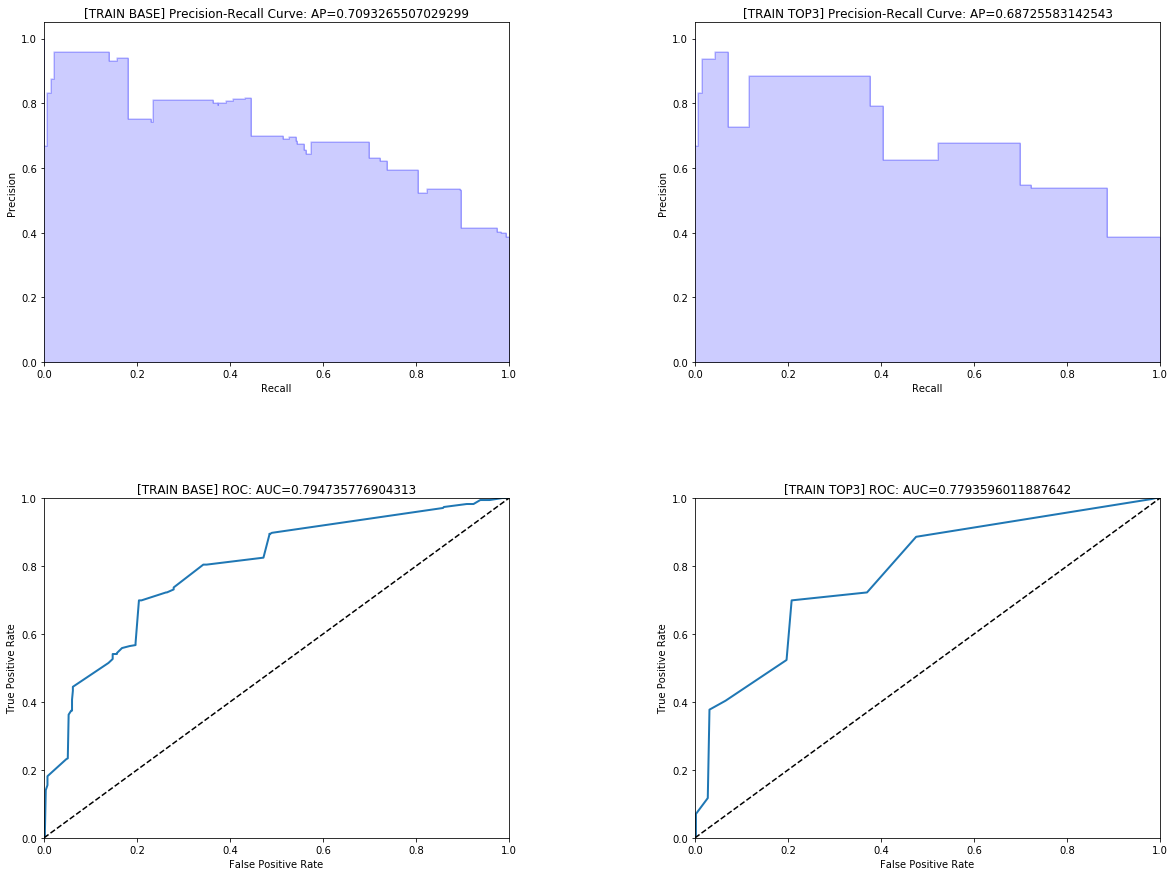

In [361]:
# Evaluate models
data_dict = {
    'TRAIN BASE': train_base,
    'TRAIN TOP3': train_top3
}

ECM = EvaluateClassificationModel(data_dict=data_dict, target=TRAIN_TARGET)
ECM.evaluate_model(SGDClassifier, model_name='Stochastic Gradient Descent')


EVALUATING Logistic Regression Model

Displaying accuracy results for  TRAIN BASE
		Scores: [0.69565217 0.82608696 0.77777778 0.77777778 0.77777778 0.77777778
 0.77777778 0.86666667 0.82222222 0.77272727 0.81818182 0.70454545
 0.75       0.88636364 0.81818182 0.77272727 0.79545455 0.77272727
 0.77272727 0.81818182]
		Mean: 0.7890667545015372
		Standard deviation: 0.04452164620391102


Displaying accuracy results for  TRAIN TOP3
		Scores: [0.76086957 0.86956522 0.77777778 0.8        0.77777778 0.75555556
 0.82222222 0.88888889 0.82222222 0.79545455 0.79545455 0.72727273
 0.75       0.79545455 0.75       0.75       0.79545455 0.81818182
 0.75       0.79545455]
		Mean: 0.7898803249890206
		Standard deviation: 0.039935789899624013


Displaying other scores for  TRAIN BASE
		Confusion Matrix:
 [[454  95]
 [ 93 249]]
		Precision score: 0.7238372093023255
		Recall score: 0.7280701754385965
		F1 score: 0.7259475218658893

Displaying other scores for  TRAIN TOP3
		Confusion Matrix:
 [[468  81]

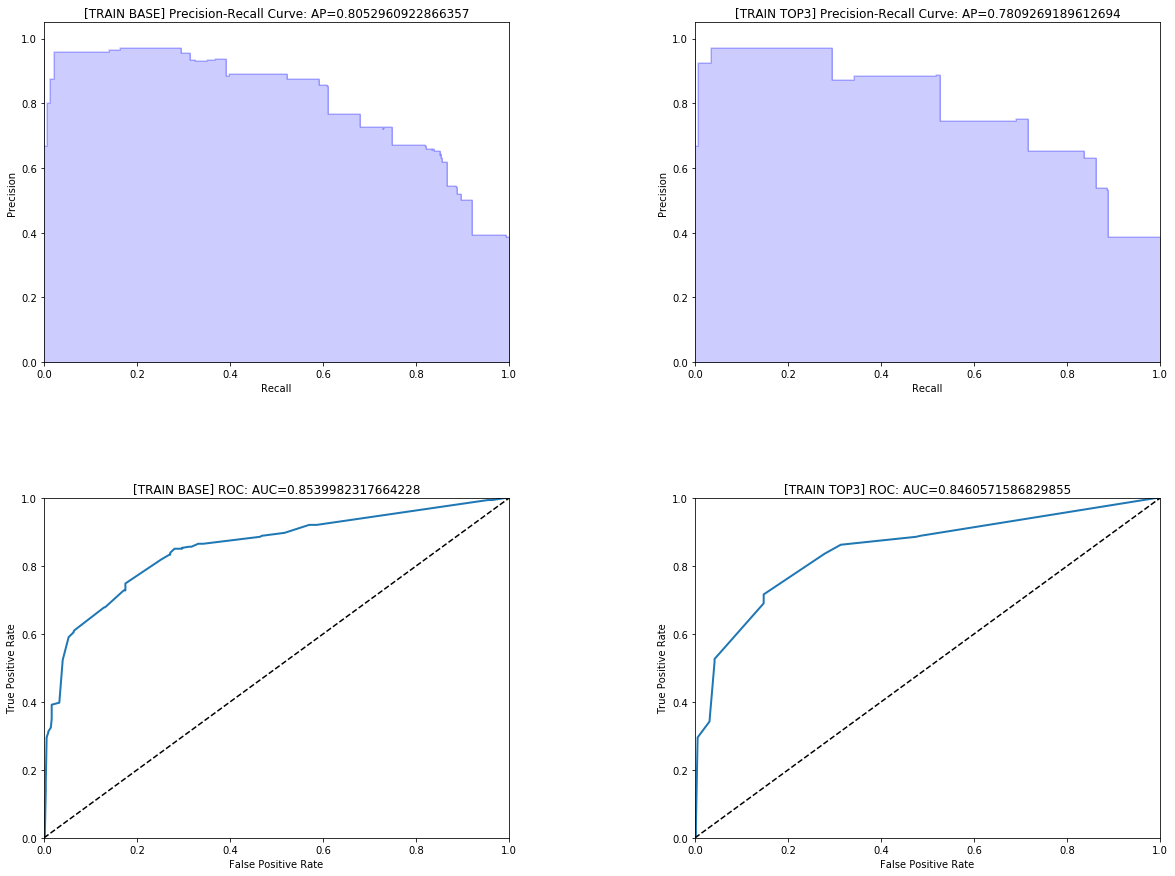

In [362]:
ECM.evaluate_model(LogisticRegression, model_name='Logistic Regression')